# DATA 607 - Machine Learning

## Class 10 &mdash; 2025.03.26 &mdash; Time feature extraction.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
def load(
    stem: str,
    base_path=Path("~/.kaggle/data/hourly-energy-consumption"),
    as_series=True,
):
    df = pd.read_csv(base_path / f"{stem}.csv")
    df = df.set_index("Datetime")
    df.index = pd.to_datetime(df.index)
    if len(df.columns == 1) and as_series:
        return df[df.columns[0]]
    else:
        return df

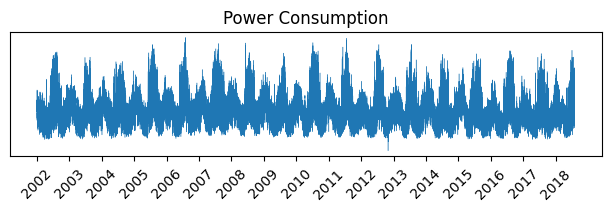

In [4]:
s = load("PJME_hourly").sort_index()
figure = plt.figure(figsize=(6, 2), layout="constrained")
plt.plot(s.index, s.values, lw=0.3)
year_starts = pd.Series(s.index.year, index=s.index).drop_duplicates(keep="first")
plt.xticks(year_starts.index, year_starts, rotation=45)
plt.yticks([])
plt.title("Power Consumption")
plt.show()

### Trend?

In [5]:
s.mean(), s.std()

(np.float64(32080.222830648156), np.float64(6464.0121664127355))

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

model = LinearRegression()
y = s.values
X = np.arange(len(y)).reshape(-1, 1)
model.fit(X, y)
model.intercept_, model.coef_.item()
rmse = root_mean_squared_error(y, model.predict(X))
rmse

6451.905255722853

In [7]:
improvement = (s.std() - rmse) / s.std()
print(f"Linear trend decreases error by {100*improvement:.2f}% over the null model.")

Linear trend decreases error by 0.19% over the null model.


### Periodicity

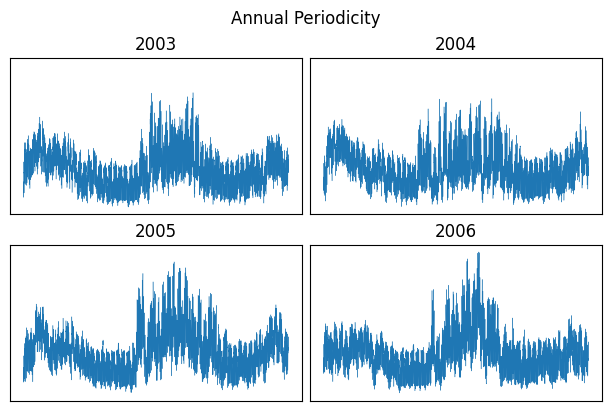

In [266]:
year = s.index.year

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(6, 4), layout="constrained", sharey=True
)
fig.suptitle("Annual Periodicity")
for y, ax in zip([2003, 2004, 2005, 2006], axes.ravel()):
    ax.plot(s[year == y].values, lw=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(y))

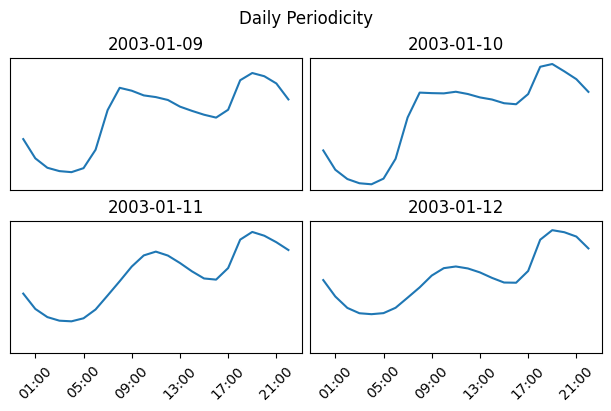

In [267]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(6, 4), layout="constrained", sharey=True
)
fig.suptitle("Daily Periodicity")
for d, ax in zip(np.arange(4) + 9, axes.ravel()):
    t = s[(year == 2003) & (s.index.dayofyear == d)]
    ax.plot(t.index.hour.values[:-1], t.values[:-1])
    if d > 10:
        hours = t.index.hour[1::4]
        ax.set_xticks(
            hours,
            [f"{h:02d}:00" for h in hours],
            rotation=45,
        )
    else:
        ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(t.index[0].date())

In [10]:
pd.Timestamp(year=2003, month=1, day=9).dayofweek

3

### Seasonality

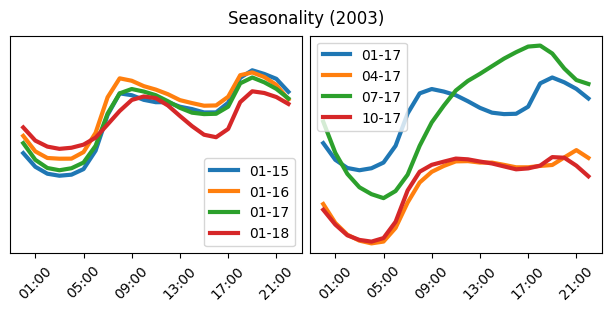

In [268]:
fig, (left, right) = plt.subplots(
    nrows=1, ncols=2, figsize=(6, 3), layout="constrained", sharey=True
)
fig.suptitle("Seasonality (2003)")

for d in np.arange(4) + 15:
    t = s[(year == 2003) & (s.index.dayofyear == d)]
    left.plot(
        t.index.hour.values[:-1],
        t.values[:-1],
        lw=3,
        label=f"{t.index[0].month:02d}-{t.index[0].day:02d}",
    )
left.legend(loc="lower right")
left.set_yticks([])
hours = t.index.hour[1::4]
left.set_xticks(
    hours,
    [f"{h:02d}:00" for h in hours],
    rotation=45,
)


for m, d in zip([1, 4, 7, 10], [17, 17, 17, 17]):
    t = s[(s.index.year == 2003) & (s.index.month == m) & (s.index.day == d)]
    right.plot(
        t.index.hour[:-1],
        t[:-1],
        lw=3,
        label=f"{t.index[0].month:02d}-{t.index[0].day:02d}",
    )
right.set_xticks(
    hours,
    [f"{h:02d}:00" for h in hours],
    rotation=45,
)
right.legend(loc="upper left")
plt.show()

In [11]:
def time_features(s):
    i = s.index
    return pd.DataFrame(
        {
            "hour": i.hour,
            "dayofweek": i.dayofweek,
            "quarter": i.quarter,
            "month": i.month,
            "dayofyear": i.dayofyear,
            "dayofmonth": i.day,
            "weekofyear": i.isocalendar().week,
        }
    )

In [12]:
X = time_features(s)
X

,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,
2002-01-01 01:00:00,1,1,1,1,1,1,1
2002-01-01 02:00:00,2,1,1,1,1,1,1
2002-01-01 03:00:00,3,1,1,1,1,1,1
2002-01-01 04:00:00,4,1,1,1,1,1,1
2002-01-01 05:00:00,5,1,1,1,1,1,1
...,...,...,...,...,...,...,...
2018-08-02 20:00:00,20,3,3,8,214,2,31
2018-08-02 21:00:00,21,3,3,8,214,2,31
2018-08-02 22:00:00,22,3,3,8,214,2,31


In [18]:
train_mask = s.index.year < 2016
test_mask = s.index.year >= 2016
X_train = X.loc[train_mask]
X_test = X.loc[test_mask]
s_train = s.loc[train_mask]
s_test = s.loc[test_mask]

In [21]:
model = LinearRegression()
model.fit(X_train, s_train)
root_mean_squared_error(s_test, model.predict(X_test))

5762.125177038508

In [24]:
one_hot_encoder = OneHotEncoder()
XX_train = one_hot_encoder.fit_transform(X_train)
XX_test = one_hot_encoder.transform(X_test)
model = LinearRegression()
model.fit(XX_train, s_train)
u = pd.Series(model.predict(XX_test), index=s_test.index)
root_mean_squared_error(s_test, u)

4265.889770537035

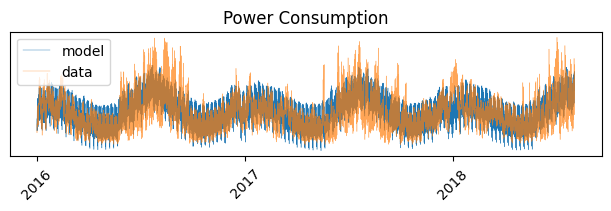

In [ ]:
figure = plt.figure(figsize=(6, 2), layout="constrained")
plt.plot(u.index, u.values, lw=0.3, label="model")
plt.plot(s_test.index, s_test.values, lw=0.3, alpha=0.7, label="data")
year_starts = pd.Series(s_test.index.year, index=s_test.index).drop_duplicates(
    keep="first"
)
plt.xticks(year_starts.index, year_starts, rotation=45)
plt.yticks([])
plt.title("Power Consumption")
plt.legend()
plt.show()

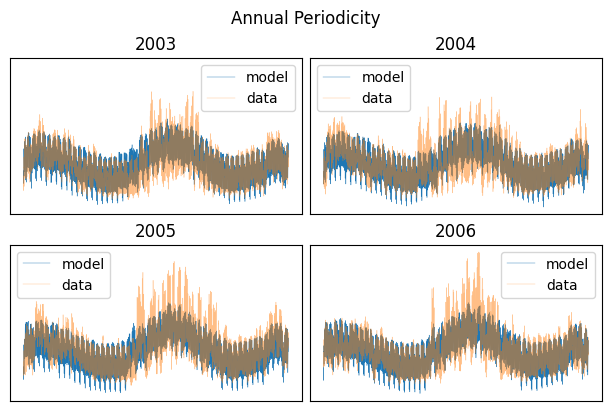

In [274]:
year = s.index.year

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(6, 4), layout="constrained", sharey=True
)
fig.suptitle("Annual Periodicity")
for y, ax in zip([2003, 2004, 2005, 2006], axes.ravel()):
    ax.plot(u[year == y].values, lw=0.3, label="model")
    ax.plot(s[year == y].values, lw=0.3, alpha=0.5, label="data")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(y))
    ax.legend()

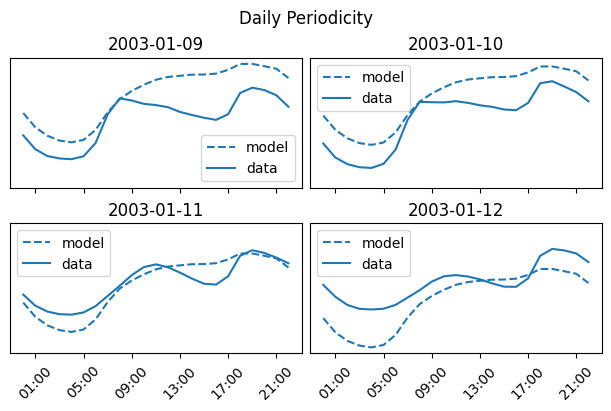

In [275]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(6, 4), layout="constrained", sharex=True, sharey=True
)
fig.suptitle("Daily Periodicity")
for d, ax in zip(np.arange(4) + 9, axes.ravel()):
    indices = (year == 2003) & (s.index.dayofyear == d)
    t = s[indices]
    ax.plot(
        u[indices].index.hour.values[:-1], u[indices].values[:-1], "C0--", label="model"
    )
    ax.plot(
        s[indices].index.hour.values[:-1], s[indices].values[:-1], "C0", label="data"
    )
    if d > 10:
        hours = s[indices].index.hour[1::4]
        ax.set_xticks(
            hours,
            [f"{h:02d}:00" for h in hours],
            rotation=45,
        )
    else:
        ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(t.index[0].date())
    ax.legend()

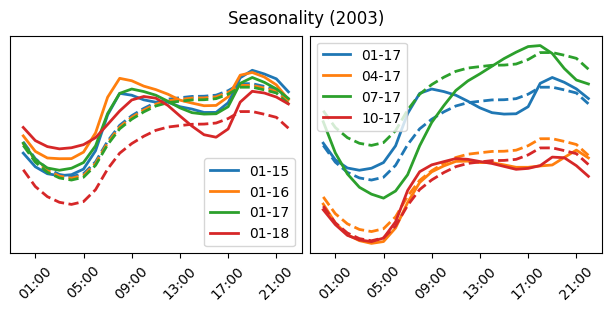

In [276]:
fig, (left, right) = plt.subplots(
    nrows=1, ncols=2, figsize=(6, 3), layout="constrained", sharey=True
)
fig.suptitle("Seasonality (2003)")

for i in np.arange(4):
    d = i + 15
    t = s[(year == 2003) & (s.index.dayofyear == d)]
    v = u[(year == 2003) & (u.index.dayofyear == d)]
    left.plot(
        t.index.hour.values[:-1],
        t.values[:-1],
        f"C{i}",
        lw=2,
        label=f"{t.index[0].month:02d}-{t.index[0].day:02d}",
    )
    left.plot(
        v.index.hour.values[:-1],
        v.values[:-1],
        f"C{i}--",
        lw=2,
    )
left.legend(loc="lower right")
left.set_yticks([])
hours = t.index.hour[1::4]
left.set_xticks(
    hours,
    [f"{h:02d}:00" for h in hours],
    rotation=45,
)


for i, (m, d) in enumerate(zip([1, 4, 7, 10], [17, 17, 17, 17])):
    t = s[(s.index.year == 2003) & (s.index.month == m) & (s.index.day == d)]
    v = u[(u.index.year == 2003) & (u.index.month == m) & (u.index.day == d)]
    right.plot(
        t.index.hour[:-1],
        t[:-1],
        f"C{i}",
        lw=2,
        label=f"{t.index[0].month:02d}-{t.index[0].day:02d}",
    )
    right.plot(
        v.index.hour[:-1],
        v[:-1],
        f"C{i}--",
        lw=2,
    )

right.set_xticks(
    hours,
    [f"{h:02d}:00" for h in hours],
    rotation=45,
)
right.legend(loc="upper left")
plt.show()

In [32]:
model = xgb.XGBRegressor(n_estimators=2000)
model.fit(X_train, s_train)
u = pd.Series(model.predict(X_test), index=s_test.index)
rmse = root_mean_squared_error(s_test, u)
rmse

4723.786578950561

In [46]:
model = xgb.XGBRegressor(n_estimators=50)
model.fit(XX_train, s_train)
u = pd.Series(model.predict(XX_test), index=s_test.index)
rmse = root_mean_squared_error(s_test, u)
rmse

3872.9557533160937

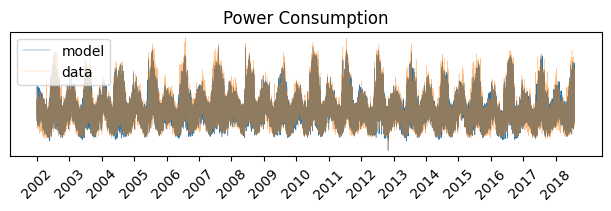

In [278]:
figure = plt.figure(figsize=(6, 2), layout="constrained")
plt.plot(u.index, u.values, lw=0.3, label="model")
plt.plot(s.index, s.values, lw=0.3, alpha=0.5, label="data")
year_starts = pd.Series(s.index.year, index=s.index).drop_duplicates(keep="first")
plt.xticks(year_starts.index, year_starts, rotation=45)
plt.yticks([])
plt.title("Power Consumption")
plt.legend()
plt.show()

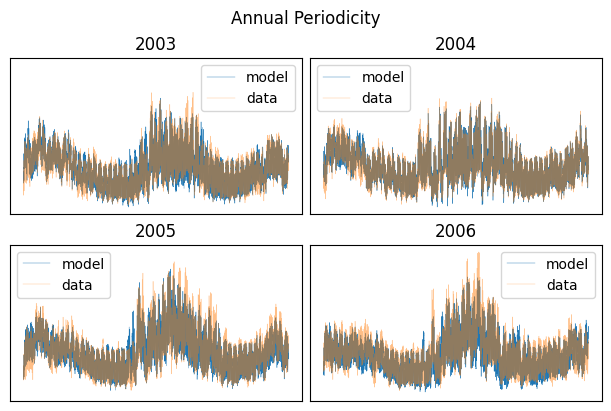

In [279]:
year = s.index.year

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(6, 4), layout="constrained", sharey=True
)
fig.suptitle("Annual Periodicity")
for y, ax in zip([2003, 2004, 2005, 2006], axes.ravel()):
    ax.plot(u[year == y].values, lw=0.3, label="model")
    ax.plot(s[year == y].values, lw=0.3, alpha=0.5, label="data")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(y))
    ax.legend()

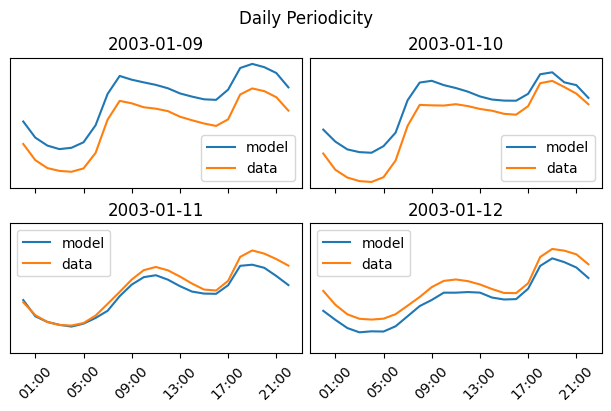

In [280]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(6, 4), layout="constrained", sharex=True, sharey=True
)
fig.suptitle("Daily Periodicity")
for d, ax in zip(np.arange(4) + 9, axes.ravel()):
    indices = (year == 2003) & (s.index.dayofyear == d)
    t = s[indices]
    ax.plot(u[indices].index.hour.values[:-1], u[indices].values[:-1], label="model")
    ax.plot(s[indices].index.hour.values[:-1], s[indices].values[:-1], label="data")
    if d > 10:
        hours = s[indices].index.hour[1::4]
        ax.set_xticks(
            hours,
            [f"{h:02d}:00" for h in hours],
            rotation=45,
        )
    else:
        ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(t.index[0].date())
    ax.legend()

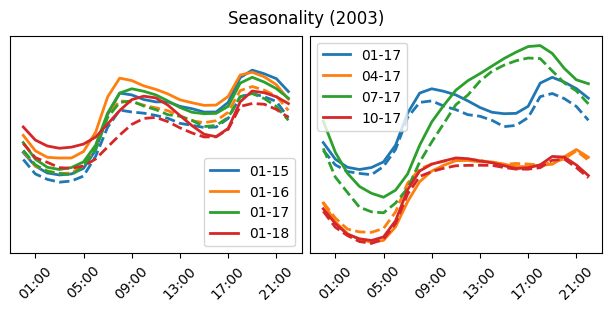

In [281]:
fig, (left, right) = plt.subplots(
    nrows=1, ncols=2, figsize=(6, 3), layout="constrained", sharey=True
)
fig.suptitle("Seasonality (2003)")

for i in np.arange(4):
    d = i + 15
    t = s[(year == 2003) & (s.index.dayofyear == d)]
    v = u[(year == 2003) & (u.index.dayofyear == d)]
    left.plot(
        t.index.hour.values[:-1],
        t.values[:-1],
        f"C{i}",
        lw=2,
        label=f"{t.index[0].month:02d}-{t.index[0].day:02d}",
    )
    left.plot(
        v.index.hour.values[:-1],
        v.values[:-1],
        f"C{i}--",
        lw=2,
    )
left.legend(loc="lower right")
left.set_yticks([])
hours = t.index.hour[1::4]
left.set_xticks(
    hours,
    [f"{h:02d}:00" for h in hours],
    rotation=45,
)


for i, (m, d) in enumerate(zip([1, 4, 7, 10], [17, 17, 17, 17])):
    t = s[(s.index.year == 2003) & (s.index.month == m) & (s.index.day == d)]
    v = u[(u.index.year == 2003) & (u.index.month == m) & (u.index.day == d)]
    right.plot(
        t.index.hour[:-1],
        t[:-1],
        f"C{i}",
        lw=2,
        label=f"{t.index[0].month:02d}-{t.index[0].day:02d}",
    )
    right.plot(
        v.index.hour[:-1],
        v[:-1],
        f"C{i}--",
        lw=2,
    )

right.set_xticks(
    hours,
    [f"{h:02d}:00" for h in hours],
    rotation=45,
)
right.legend(loc="upper left")
plt.show()